#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_validate
from joblib import Parallel, delayed

Read the spectral data

In [2]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,31.645788
1,201210-1-00,294,400.91116,201210-1,Normal,31.890799
2,201210-1-00,295,401.59454,201210-1,Normal,32.060592
3,201210-1-00,296,402.27789,201210-1,Normal,32.161890
4,201210-1-00,297,402.96127,201210-1,Normal,32.201418
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-17.773341
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-16.954783
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-16.058237
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-15.079158


#### **1 Sample Examples**

In [4]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber     SurID         Status  Absorbance
6206421  210526-3-04   293   400.22778  210526-3  Hyperglycemia    0.828610
6206422  210526-3-04   294   400.91116  210526-3  Hyperglycemia   10.985219
6206423  210526-3-04   295   401.59454  210526-3  Hyperglycemia   19.483125
6206424  210526-3-04   296   402.27789  210526-3  Hyperglycemia   26.425142
6206425  210526-3-04   297   402.96127  210526-3  Hyperglycemia   31.914082
...              ...   ...         ...       ...            ...         ...
6208465  210526-3-04  2337  1797.03870  210526-3  Hyperglycemia  -26.713419
6208466  210526-3-04  2338  1797.72200  210526-3  Hyperglycemia  -26.432244
6208467  210526-3-04  2339  1798.40550  210526-3  Hyperglycemia  -26.273720
6208468  210526-3-04  2340  1799.08890  210526-3  Hyperglycemia  -26.248190
6208469  210526-3-04  2341  1799.77220  210526-3  Hyperglycemia  -26.365997

[2049 rows x 6 columns]


Find Peaks Within the spectrum.

In [5]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

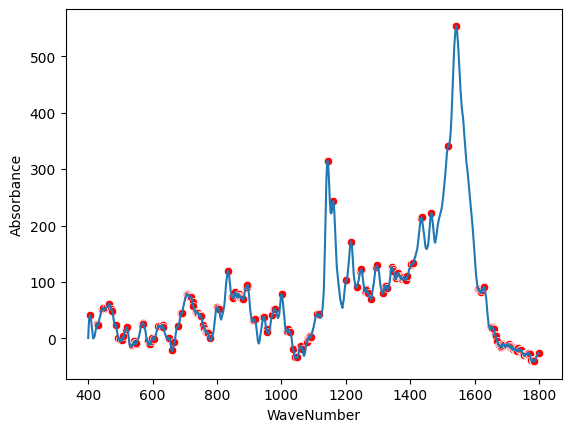

In [6]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [7]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

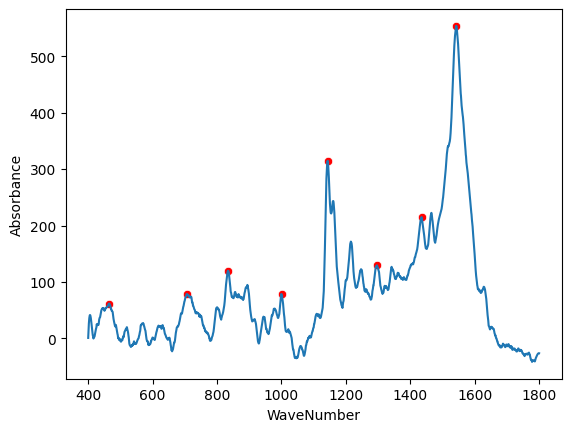

In [8]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [9]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

#### **1. Using Peak Statistics**

In [10]:
backup = df

In [11]:
statuses = df[['SpecID', 'Status']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [12]:
peaks = []
widths = []
prominences = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])


    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_20408\3839389258.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
C:\Users\FX 8320\AppData\Local\Temp\ipykernel_20408\3839389258.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [13]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
4,201210-1-00,297,402.96127,201210-1,Normal,32.201418,6.469735,0.555630
20,201210-1-00,313,413.89520,201210-1,Normal,32.744039,0.609705,0.127398
23,201210-1-00,316,415.94534,201210-1,Normal,33.376393,4.920541,3.222732
26,201210-1-00,319,417.99545,201210-1,Normal,30.872730,0.862466,0.374425
31,201210-1-00,324,421.41229,201210-1,Normal,28.645988,2.275627,1.255784
...,...,...,...,...,...,...,...,...
6228917,210526-3-49,2299,1771.07060,210526-3,Hyperglycemia,-9.144178,8.010987,3.079292
6228922,210526-3-49,2304,1774.48740,210526-3,Hyperglycemia,-10.204847,1.683529,0.643009
6228931,210526-3-49,2313,1780.63780,210526-3,Hyperglycemia,-13.651002,1.039733,1.138803
6228939,210526-3-49,2321,1786.10470,210526-3,Hyperglycemia,-17.688128,0.792396,0.099836


In [14]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [15]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [16]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [17]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,33.590344,34.594272,251,159.095461,-26.402516,5.051673,16.769826,200.216791,0.502550,4.483874,18.800052,169.775455,0.002746
1,201210-1-01,36.490851,44.288630,216,206.147390,-32.590469,5.117660,14.065389,147.630935,0.503152,6.393594,26.533805,223.590382,0.006419
2,201210-1-02,63.466734,129.274420,182,1464.499730,-79.027032,4.775708,9.892271,55.950546,0.503520,18.547456,123.894318,1499.356120,0.010434
3,201210-1-03,100.391970,182.055250,151,998.434555,-113.170559,5.440494,11.403335,63.376129,0.501245,29.869794,146.267824,1060.096242,0.004750
4,201210-1-04,64.777083,71.300565,215,306.678766,-55.324916,5.716222,18.453179,197.787362,0.501506,7.107753,31.103420,363.817836,0.001538


In [18]:
peak_stats.shape

(3045, 14)

In [19]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [20]:
peak_stats.shape

(3045, 14)

In [21]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6355 +/- 0.0190


##### **Find the best Peak Finding Parameters for the Stat Based Approach**

In [22]:
df = df.drop(columns=['Seq', 'SurID'])

In [23]:
df

,SpecID,WaveNumber,Status,Absorbance
0,201210-1-00,400.22778,Normal,31.645788
1,201210-1-00,400.91116,Normal,31.890799
2,201210-1-00,401.59454,Normal,32.060592
3,201210-1-00,402.27789,Normal,32.161890
4,201210-1-00,402.96127,Normal,32.201418
...,...,...,...,...
6239200,210526-3-09,1797.03870,Hyperglycemia,-17.773341
6239201,210526-3-09,1797.72200,Hyperglycemia,-16.954783
6239202,210526-3-09,1798.40550,Hyperglycemia,-16.058237
6239203,210526-3-09,1799.08890,Hyperglycemia,-15.079158


In [24]:
# Define parameter ranges

## Test Search
# distances = [None, 5]
# prominences = [None, 0.01]
# widths = [None, 5]
# thresholds = [None, 0.01]

# First Search
distances = [None, 5, 10, 25, 50, 100, 150, 200, 250]
prominences = [None, 5, 10, 25, 50, 100, 150, 200, 250]
widths = [None, 0.5, 1, 2, 3, 4, 5, 8]
thresholds = [None, 5, 10, 25, 50]

In [25]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [26]:
def preprocess_and_extract_peaks(df, distance, prominence, width, threshold):
    
    widths = []
    prominences = []
    peaks = []
    
    for _, group in df.groupby('SpecID'):

        peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)

        # Calculate the widths of each peak
        widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

        # Calculate prominence of each peak
        prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

        # Find the index of the peak within the full dataframe
        peaks += list(group.iloc[peak_index].index.values)

    peaks_df = df.loc[peaks].copy()
    peaks_df['PeakWidths'] = widths
    peaks_df['PeakProminences'] = prominences
    return peaks_df

In [27]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Create a new DataFrame for the summary statistics
    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidths': ['mean', 'std', 'max', 'min'],
        'PeakProminences': ['mean', 'std', 'max', 'min']
    }).reset_index()

    # Flatten the multi-level columns and customise the names
    peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']
    
    # Add the statuses back to the dataframe
    peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left').set_index('SpecID').fillna(0)

    X = peak_stats.drop(['Status'], axis=1)
    y = peak_stats['Status']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

# results = []
# for d in distances:
#     for p in prominences:
#         for w in widths:
#             for t in thresholds:
#                 results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [28]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("Peak_Stat_Parameters.csv", index=False)

Best Parameters: Distance=nan, Prominence=nan, Width=nan, Thresholde=nan and Avg_Peak_Count=168.01 with Accuracy: 0.6355


#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [29]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

In [30]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_20408\3718610318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [31]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
4,201210-1-00,297,402.96127,201210-1,Normal,32.201418,6.469735,0.555630,400-425
20,201210-1-00,313,413.89520,201210-1,Normal,32.744039,0.609705,0.127398,400-425
23,201210-1-00,316,415.94534,201210-1,Normal,33.376393,4.920541,3.222732,400-425
26,201210-1-00,319,417.99545,201210-1,Normal,30.872730,0.862466,0.374425,400-425
31,201210-1-00,324,421.41229,201210-1,Normal,28.645988,2.275627,1.255784,400-425


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to 0.
If multiple peaks appear their properties are aggregated.

In [32]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with 0
peak_bins.fillna(0, inplace=True)

In [33]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,79.348488,51.220241,56.270595,43.622056,9.791624,23.050053,11.951954,-2.060928,-4.324703,28.507881,...,1.079688,5.605290,1.425452,9.092851,4.989642,29.439388,1.346161,1.716824,1.339044,Normal
201210-1-01,77.237541,33.905318,49.270501,31.586800,3.304689,21.400157,14.579625,9.078719,-10.360994,0.805333,...,0.911928,1.412806,0.554703,2.452688,0.921724,70.524064,19.421840,0.812030,12.108906,Normal
201210-1-02,132.816715,187.442220,69.677144,56.429799,12.626494,67.955977,29.686681,-3.111961,5.960533,25.575162,...,1.582275,1.030469,1.663810,1.639609,0.000000,29.350815,0.000000,1.796942,3.345436,Normal
201210-1-03,371.600578,212.368633,210.376974,129.626363,125.077805,0.000000,625.666908,0.000000,37.979164,77.983322,...,0.000000,1.473284,1.069089,0.000000,0.000000,63.376129,0.000000,60.423360,1.246936,Normal
201210-1-04,82.989091,33.333771,35.816497,10.215812,6.639818,37.646776,56.228362,87.822719,41.492328,36.294090,...,1.971683,2.140093,2.146750,16.566306,2.824986,5.762471,3.919114,1.001860,1.682968,Normal


In [34]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.8407 +/- 0.0151


##### **Find the best Peak Finding Parameters for the Bin Based Approach**

In [35]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Set the bin size
    bin_size = 25

    # Add a "Bin" column to the DataFrame
    peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))
    
    # Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
    peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
    peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
    peak_bins.reset_index(inplace=True)

    # Merge with 'Status' information
    peak_bins = pd.merge(statuses, peak_bins, on='SpecID', how='left')

    # Set 'SpecID' as the index
    peak_bins.set_index('SpecID', inplace=True)

    # Fill NaN values with 0
    peak_bins.fillna(0, inplace=True)
    
    X = peak_bins.drop(['Status'], axis=1)
    y = peak_bins['Status']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    scores = cross_validate(et, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

# results = []
# for d in distances:
#     for p in prominences:
#         for w in widths:
#             for t in thresholds:
#                 results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [36]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("Peak_Bin_Parameters.csv", index=False)

Best Parameters: Distance=nan, Prominence=nan, Width=nan, Thresholde=nan and Avg_Peak_Count=168.01 with Accuracy: 0.8407
